In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
from scipy.optimize import curve_fit
import metpy.calc as mpcalc
from metpy.units import units
import scipy
import metpy
mpl.rcParams['figure.dpi']= 300

In [2]:
import warnings;
warnings.filterwarnings('ignore');

In [3]:
#model2 = '/media/rakshith/Seagate Expansion Drive/Good models/CMCC/*.nc'
#cmcc = xr.open_mfdataset(model2)

model2 = '/media/rakshith/Seagate Expansion Drive/Good models/INM-CM5-0/*.nc'
inm = xr.open_mfdataset(model2)

#model2 = '/media/rakshith/Seagate Expansion Drive/Good models/E3SM-1-0/*.nc'
#e3sm = xr.open_mfdataset(model2)

#model4 = '/media/rakshith/Seagate Expansion Drive/Good models/MIROC6/*.nc'
#miroc = xr.open_mfdataset(model4)

In [4]:
data=inm

In [6]:
#grid1 = data.sel(lat=slice(10,30), lon=slice(70,90))
grid1 = data.sel(lat=slice(0,30))

In [12]:
months = grid1.time.dt.month.isin(range(6, 10))
JJAS = grid1.sel(time=months)

l=[]
for i in grid1.lon:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, grid1.lat)
mask1 = globe.is_land(lat_grid, lon_grid)

In [13]:
clim=JJAS.resample(time="10AS").mean('time')

In [14]:
Pwat = clim.prw.where(mask1>0).mean(dim=['lat', 'lon'])
P = 86400*28.96*((clim.pr.where(mask1>0).mean(dim=['lat', 'lon'])-clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon'])))
Qdiv = clim.rsdt.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rsut.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rlut.where(mask1>0).mean(dim=['lat', 'lon'])
E = 86400*28.96*(clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon']))
Pr = 86400*(clim.pr.where(mask1>0).mean(dim=['lat', 'lon']))

In [15]:
def pred(p,qnet,pwat):
    return pwat*((qnet/p)+1)

pred1 = pred(P.values, Qdiv.values, Pwat.values)

In [18]:
X = np.arange(1850, 2110, 10)

In [51]:
X1 = np.arange(1950, 2110, 10)

In [26]:
#for India
const = np.array([68.24124667, 68.15998929, 68.80209649, 69.64591805, 69.56235731,
       70.78630872, 72.00686236, 72.72516124, 74.299387  , 75.79479184,
       77.28963371, 79.7440898 , 80.84100299, 82.57529192, 84.6679651 ,
       86.57084635])

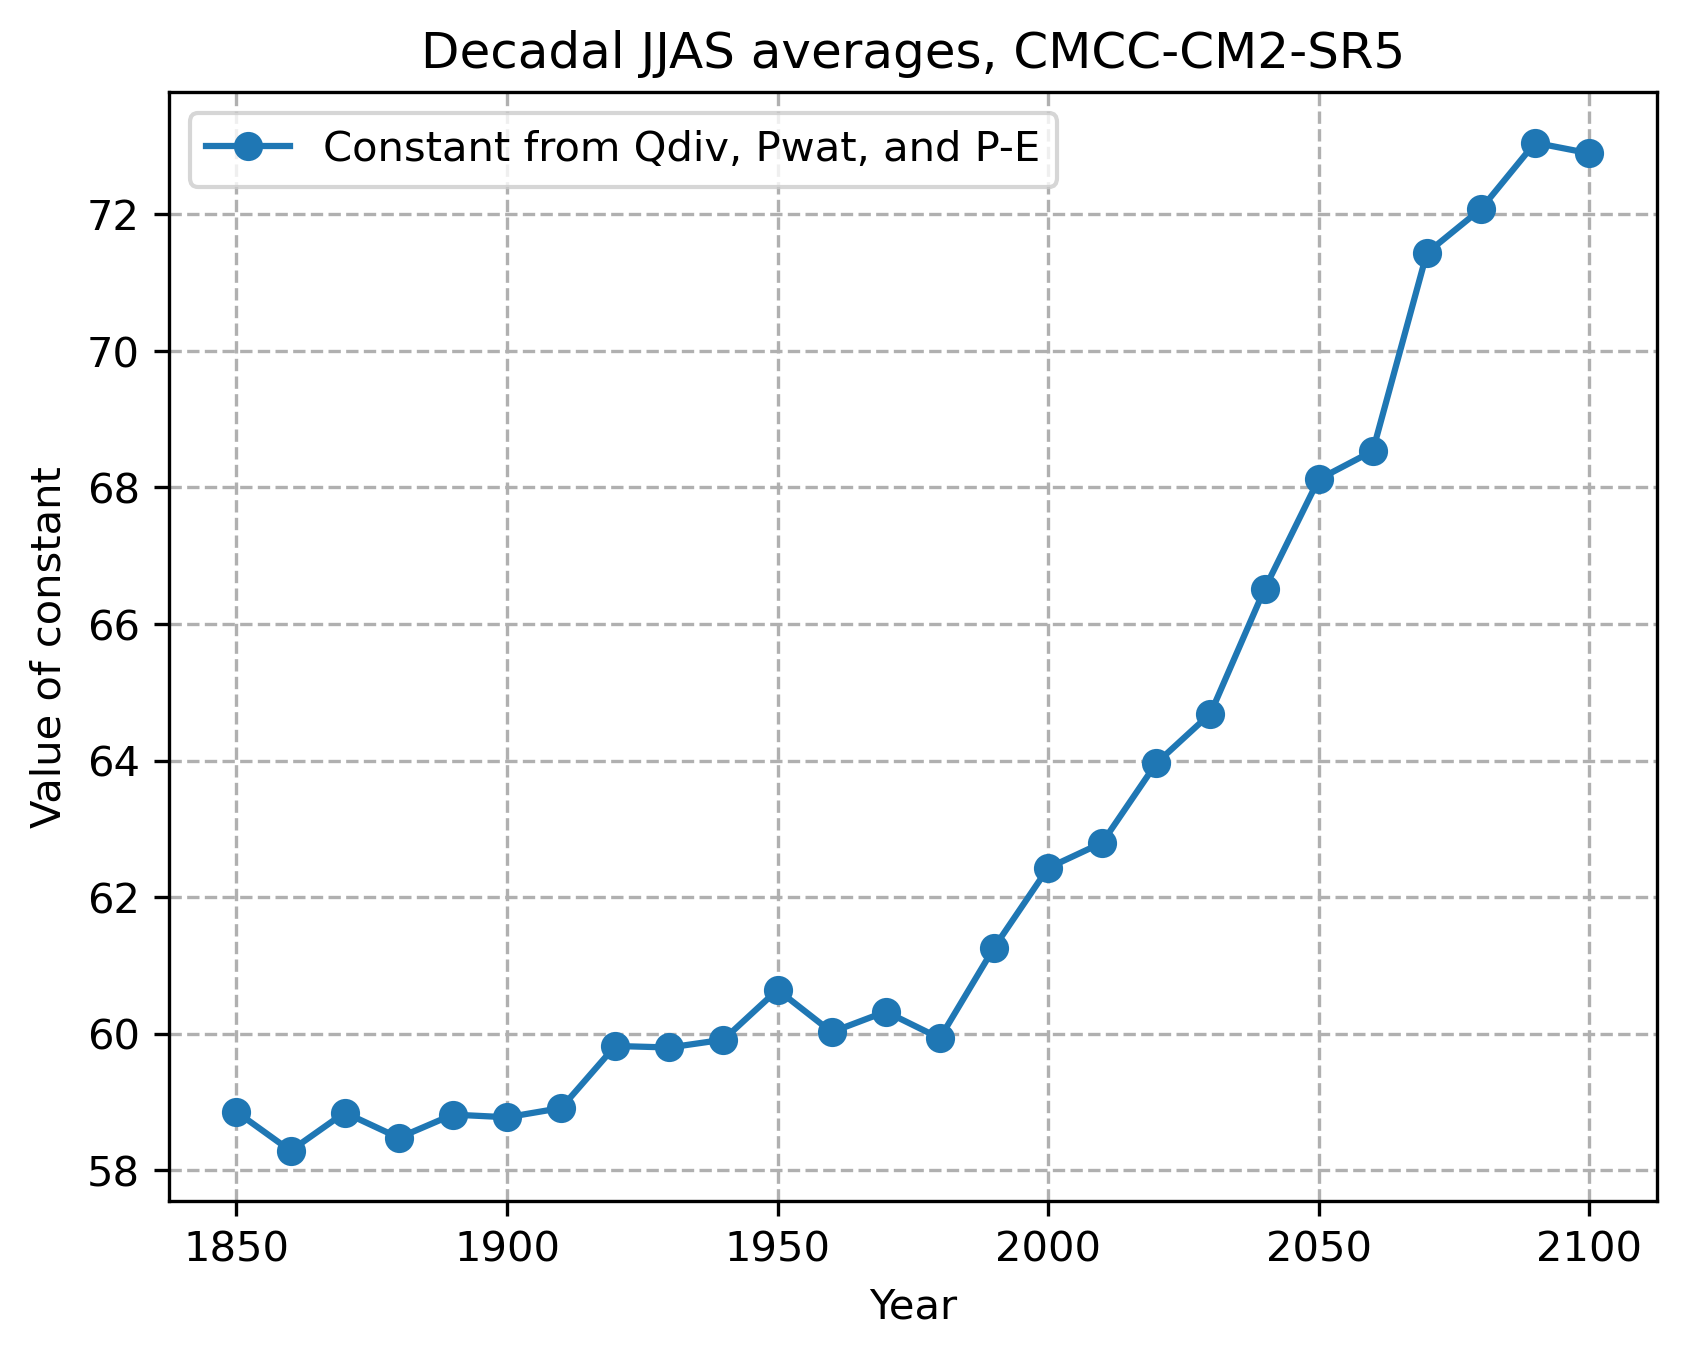

In [19]:
plt.plot(X, pred1, marker='o', label='Constant from Qdiv, Pwat, and P-E')
#plt.plot(X1, const, marker='o', label='Constant from gamma and lambda')
plt.ylabel('Value of constant')
plt.xlabel('Year')
plt.title('Decadal JJAS averages, CMCC-CM2-SR5')
plt.grid(linestyle='--')
#plt.figtext(0.4, 0.75, 'c = Pwat*((Qdiv/(P-E))+1)')
plt.legend()

In [20]:
def func(e,c,qnet,pwat):
    return e + qnet/((c/Pwat)-1)

predprec = func(E.values, pred1, Qdiv.values, Pwat.values)

In [21]:
Value = predprec.values/28.96

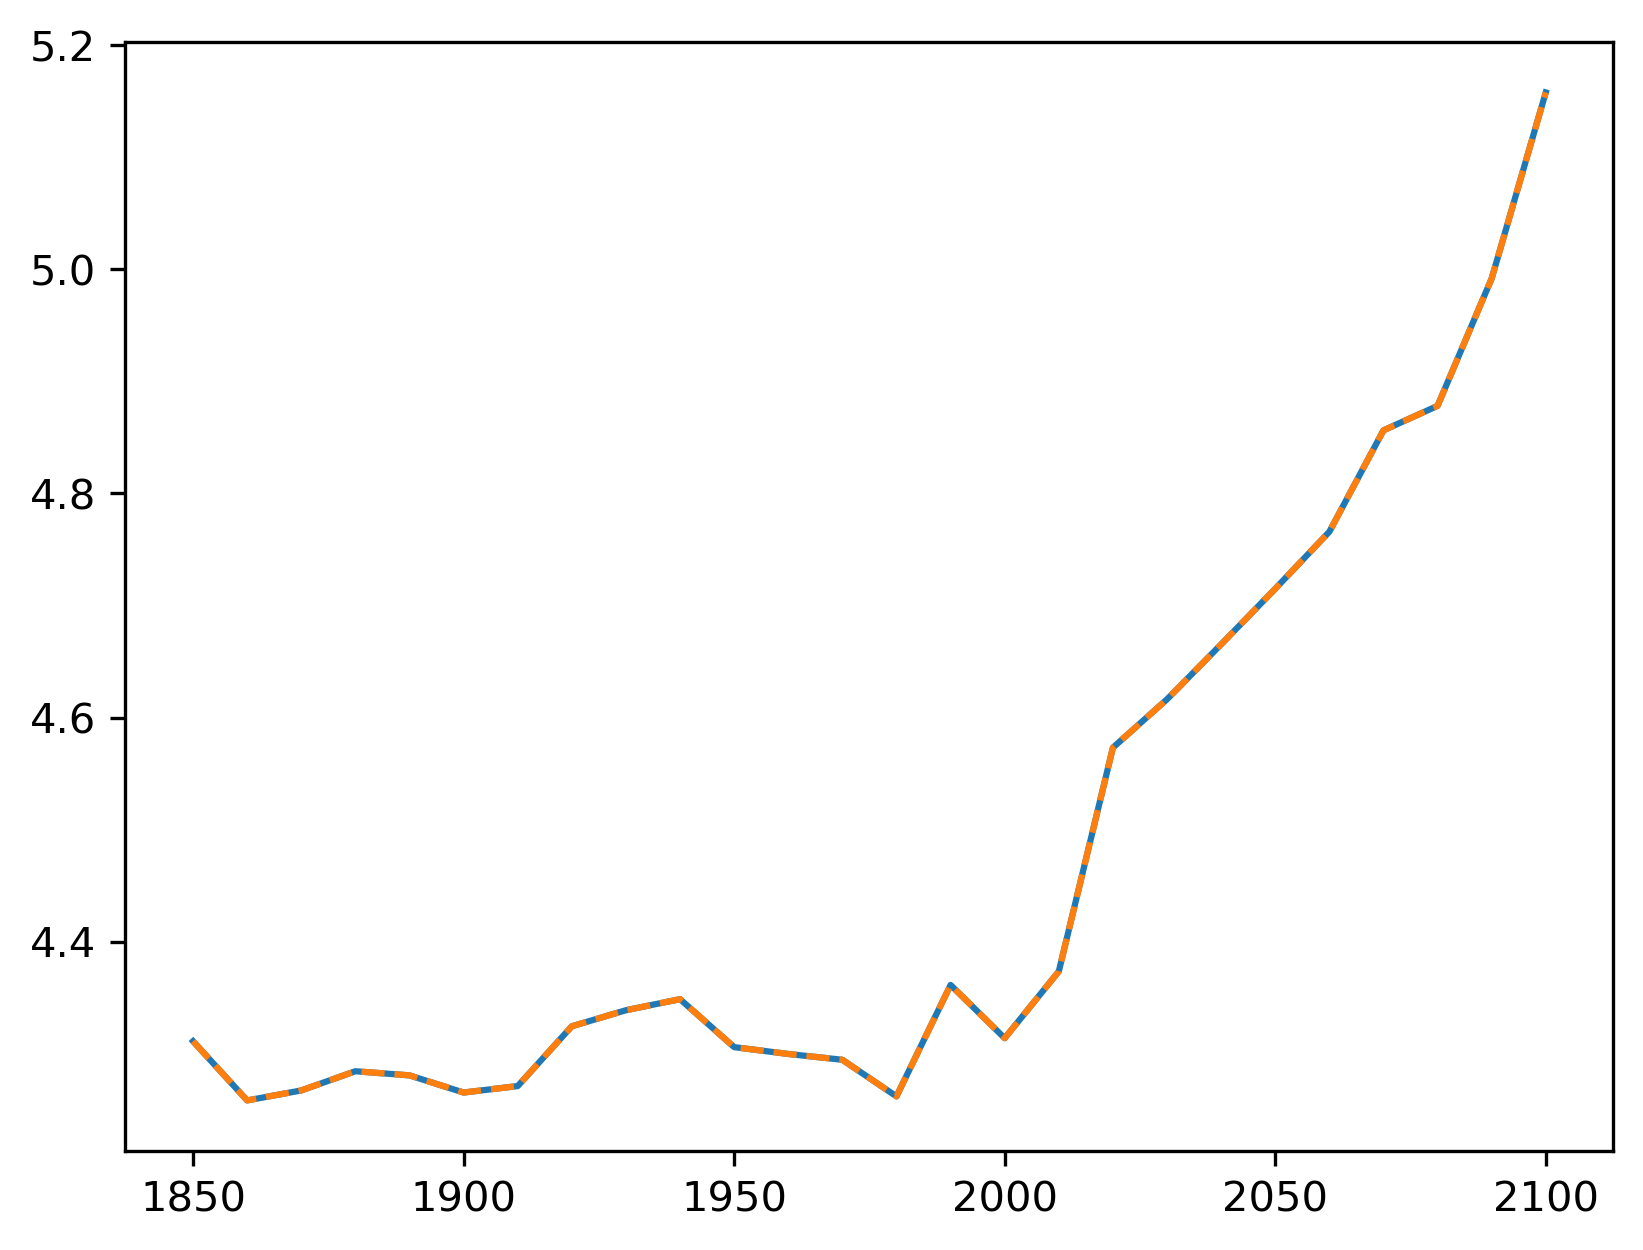

In [22]:
plt.plot(X, Pr)
plt.plot(X, Value, linestyle='--')